In [67]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from fcmeans import FCM
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import skfuzzy as fuzz
from skfuzzy import control as ctrl 
from scipy.interpolate import interp1d

In [68]:
df = pd.read_csv('preprocessed_inventory_data.csv')
# Filter data for the first three months: 2022-01 to 2022-03
df = df[(pd.to_datetime(df['Month']) >= '2022-01-01') & (pd.to_datetime(df['Month']) <= '2022-03-31')]
# Display the filtered data
print(df.tail())

      Month Product_ID  Sales_Speed  Stock_Level     Category  Lead_Time  \
55  2022-03      P0016          373          333    Furniture         13   
56  2022-03      P0017          403          450     Clothing         10   
57  2022-03      P0018          370          338  Electronics         17   
58  2022-03      P0019          411          441         Toys         22   
59  2022-03      P0020          379          295    Furniture         13   

    Price  
55  35.59  
56  70.94  
57  98.00  
58  57.70  
59  34.13  


In [69]:
# Use one variable at a time, e.g., Sales_Speed
sales_speed_reshaped = df['Sales_Speed'].values.reshape(-1, 1)
stock_level_reshaped = df['Stock_Level'].values.reshape(-1, 1)
lead_time_reshaped = df['Lead_Time'].values.reshape(-1, 1)
selling_price_reshaped = df['Price'].values.reshape(-1, 1)

max_sales = df['Sales_Speed'].max()
max_stock = df['Stock_Level'].max()
max_lead = df['Lead_Time'].max()
max_price = df['Price'].max() # Use the max from the original 1D pandas Series
sales_range = np.linspace(0, max_sales * 1.1, 1000)
stock_range = np.linspace(0, max_stock * 1.1, 1000)
lead_range = np.linspace(0, max_lead * 1.1, 1000)
price_range = np.linspace(0, max_price * 1.1, 1000) # price_range is now created from a scalar
# Define the universe for urgency separately as you did before
urgency_range = np.linspace(0, 10, 1000)

# Create fuzzy variables
sales = ctrl.Antecedent(sales_range, 'sales')
stock = ctrl.Antecedent(stock_range, 'stock')
lead = ctrl.Antecedent(lead_range, 'lead_time')
price = ctrl.Antecedent(price_range, 'price')
urgency = ctrl.Consequent(urgency_range, 'restock_urgency') 


# Now use the reshaped data for FCM fitting in subsequent cells
sales_speed = sales_speed_reshaped
stock_level = stock_level_reshaped
lead_time = lead_time_reshaped
selling_price = selling_price_reshaped

Cluster centers: [ 95.30852572 211.76901412 372.72013059]


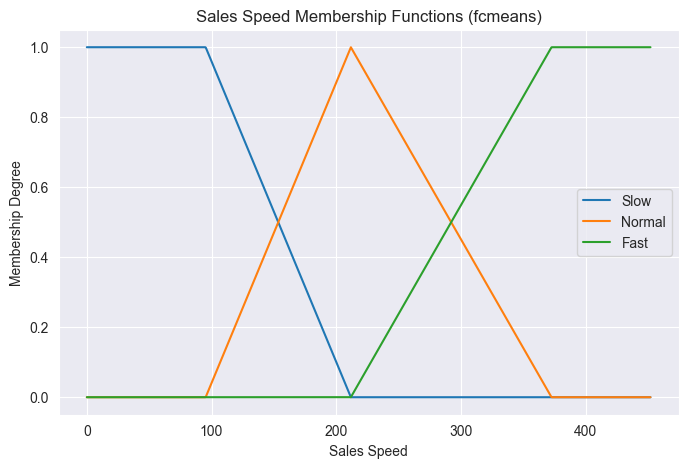

In [70]:
# Instantiate the FCM model with 3 clusters (Slow, Normal, Fast)
fcm = FCM(n_clusters=3, random_state=42)
fcm.fit(sales_speed)

# Get the cluster centers and membership matrix
centers = fcm.centers.flatten()
u = fcm.u # Membership degrees (shape: n_samples x n_clusters)

print("Cluster centers:", centers)
# Sort centers and match the memberships accordingly
sorted_idx = np.argsort(centers)
sorted_centers = centers[sorted_idx]
sorted_u = u[:, sorted_idx]

# Plot learned membership functions (fuzzy sets)
# x_vals = np.linspace(min(sales_speed), max(sales_speed), 1000)
x_vals = np.linspace(0, max(sales_speed) * 1.1, 1000).flatten()

def create_membership_function(center_idx, centers):
    center = centers[center_idx]
    mf = np.zeros_like(x_vals)  # Ensure correct shape
        
    if center_idx == 0:
        # Left shoulder (Slow): extend left
        right = centers[center_idx + 1]
        left = max(0, center - (right - center) * 1.5)
        mf = np.clip((right - x_vals) / (right - center), 0, 1)
        mf[x_vals <= left] = 1.0  # Flat shoulder at 1
    
    elif center_idx == len(centers) - 1:
        # Right shoulder (Fast): extend right
        left = centers[center_idx - 1]
        right = center + (center - left) * 1.5
        mf = np.clip((x_vals - left) / (center - left), 0, 1)
        mf[x_vals >= right] = 1.0  # Flat shoulder at 1
    
    else:
        # Middle triangular (Normal)
        left = centers[center_idx - 1]
        right = centers[center_idx + 1]
        mf = np.clip((x_vals - left) / (center - left), 0, 1) * \
             np.clip((right - x_vals) / (right - center), 0, 1)
        
    return mf

plt.figure(figsize=(8, 5))
labels = ['Slow', 'Normal', 'Fast']
# Flatten arrays to ensure they are 1D
x_vals_flat = x_vals.flatten()
universe_flat = sales.universe.flatten()

for i, label in enumerate(labels):
    mf = create_membership_function(i, sorted_centers)
    plt.plot(x_vals, mf, label=label)
    # Interpolation function to project the MF onto the fuzzy universe
    interp_func = interp1d(x_vals_flat, mf, bounds_error=False, fill_value=0)
    # Evaluate it over the universe and assign
    interpolated_mf = interp_func(universe_flat)
    # Assign the membership function (must match universe shape)
    sales[label] = interpolated_mf
    
plt.title("Sales Speed Membership Functions (fcmeans)")
plt.xlabel("Sales Speed")
plt.ylabel("Membership Degree")
plt.legend()
plt.grid(True)
plt.show()

Cluster centers: [121.14346661 276.51521158 423.03394943]


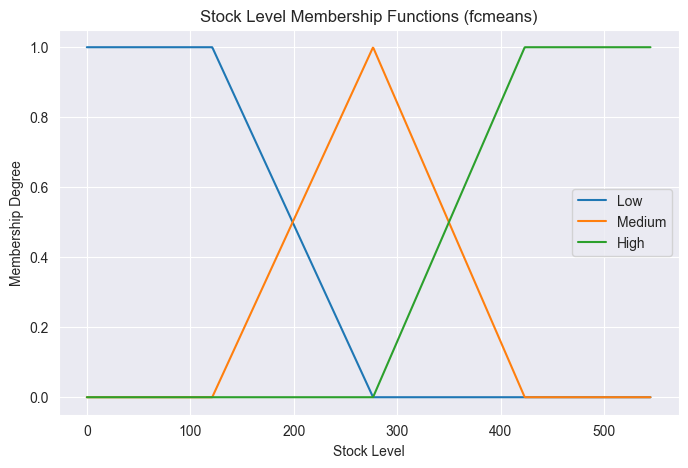

In [71]:
# Instantiate the FCM model with 3 clusters (Low, Medium, High)
fcm = FCM(n_clusters=3, random_state=42)
fcm.fit(stock_level)

# Get the cluster centers and membership matrix
centers = fcm.centers.flatten()
u = fcm.u # Membership degrees (shape: n_samples x n_clusters)

print("Cluster centers:", centers)

# Sort centers and match the memberships accordingly
sorted_idx = np.argsort(centers)
sorted_centers = centers[sorted_idx]
sorted_u = u[:, sorted_idx]

# Plot learned membership functions (fuzzy sets)
# x_vals = np.linspace(0, max(stock_level) * 1.1, 1000)
x_vals = np.linspace(0, max(stock_level) * 1.1, 1000).flatten()

def create_membership_function(center_idx, centers):
    center = centers[center_idx]
    mf = np.zeros_like(x_vals)  # Ensure correct shape
    
    if center_idx == 0:
        # Left shoulder (Slow): extend left
        right = centers[center_idx + 1]
        left = max(0, center - (right - center) * 1.5)
        mf = np.clip((right - x_vals) / (right - center), 0, 1)
        mf[x_vals <= left] = 1.0  # Flat shoulder at 1
    
    elif center_idx == len(centers) - 1:
        # Right shoulder (Fast): extend right
        left = centers[center_idx - 1]
        right = center + (center - left) * 1.5
        mf = np.clip((x_vals - left) / (center - left), 0, 1)
        mf[x_vals >= right] = 1.0  # Flat shoulder at 1
    
    else:
        # Middle triangular (Normal)
        left = centers[center_idx - 1]
        right = centers[center_idx + 1]
        mf = np.clip((x_vals - left) / (center - left), 0, 1) * \
             np.clip((right - x_vals) / (right - center), 0, 1)
        
    return mf

plt.figure(figsize=(8, 5))
labels = ['Low', 'Medium', 'High']
# Flatten arrays to ensure they are 1D
x_vals_flat = x_vals.flatten()
universe_flat = stock.universe.flatten()

for i, label in enumerate(labels):
    mf = create_membership_function(i, sorted_centers)
    plt.plot(x_vals, mf, label=label)
    # Interpolation function to project the MF onto the fuzzy universe
    interp_func = interp1d(x_vals_flat, mf, bounds_error=False, fill_value=0)
    # Evaluate it over the universe and assign
    interpolated_mf = interp_func(universe_flat)
    # Assign the membership function (must match universe shape)
    stock[label] = interpolated_mf

plt.title("Stock Level Membership Functions (fcmeans)")
plt.xlabel("Stock Level")
plt.ylabel("Membership Degree")
plt.legend()
plt.grid(True)
plt.show()


Cluster centers: [21.97316368 16.68699701 10.17501065]


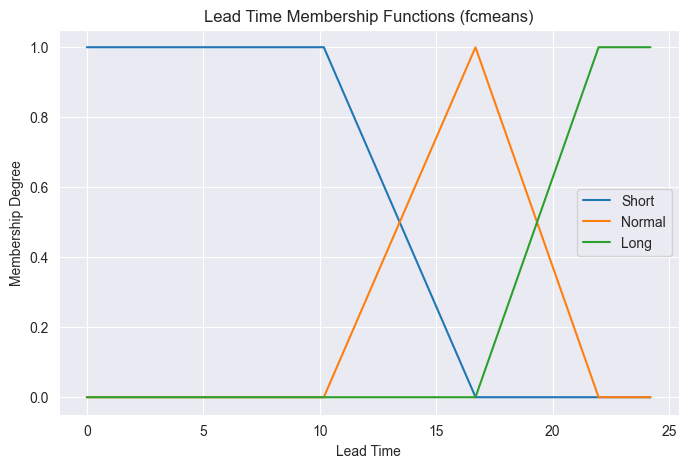

In [72]:
# Instantiate the FCM model with 3 clusters (Short, Normal, Long)
fcm = FCM(n_clusters=3, random_state=42)
fcm.fit(lead_time)

# Get the cluster centers and membership matrix
centers = fcm.centers.flatten()
u = fcm.u # Membership degrees (shape: n_samples x n_clusters)

print("Cluster centers:", centers)

# Sort centers and match the memberships accordingly
sorted_idx = np.argsort(centers)
sorted_centers = centers[sorted_idx]
sorted_u = u[:, sorted_idx]

# Plot learned membership functions (fuzzy sets)
x_vals = np.linspace(0, max(lead_time) * 1.1, 1000).flatten()

def create_membership_function(center_idx, centers):
    center = centers[center_idx]
    
    if center_idx == 0:
        # Left shoulder (Slow): extend left
        right = centers[center_idx + 1]
        left = max(0, center - (right - center) * 1.5)
        mf = np.clip((right - x_vals) / (right - center), 0, 1)
        mf[x_vals <= left] = 1.0  # Flat shoulder at 1
    
    elif center_idx == len(centers) - 1:
        # Right shoulder (Fast): extend right
        left = centers[center_idx - 1]
        right = center + (center - left) * 1.5
        mf = np.clip((x_vals - left) / (center - left), 0, 1)
        mf[x_vals >= right] = 1.0  # Flat shoulder at 1
    
    else:
        # Middle triangular (Normal)
        left = centers[center_idx - 1]
        right = centers[center_idx + 1]
        mf = np.clip((x_vals - left) / (center - left), 0, 1) * \
             np.clip((right - x_vals) / (right - center), 0, 1)
        
    return mf

plt.figure(figsize=(8, 5))
labels = ['Short', 'Normal', 'Long']
# Flatten arrays to ensure they are 1D
x_vals_flat = x_vals.flatten()
universe_flat = lead.universe.flatten()

for i, label in enumerate(labels):
    mf = create_membership_function(i, sorted_centers)
    plt.plot(x_vals, mf, label=label)
    # Interpolation function to project the MF onto the fuzzy universe
    interp_func = interp1d(x_vals_flat, mf, bounds_error=False, fill_value=0)
    # Evaluate it over the universe and assign
    interpolated_mf = interp_func(universe_flat)
    # Assign the membership function (must match universe shape)
    lead[label] = interpolated_mf

plt.title("Lead Time Membership Functions (fcmeans)")
plt.xlabel("Lead Time")
plt.ylabel("Membership Degree")
plt.legend()
plt.grid(True)
plt.show()

Cluster centers: [91.88247313 29.25748549 65.55791249]


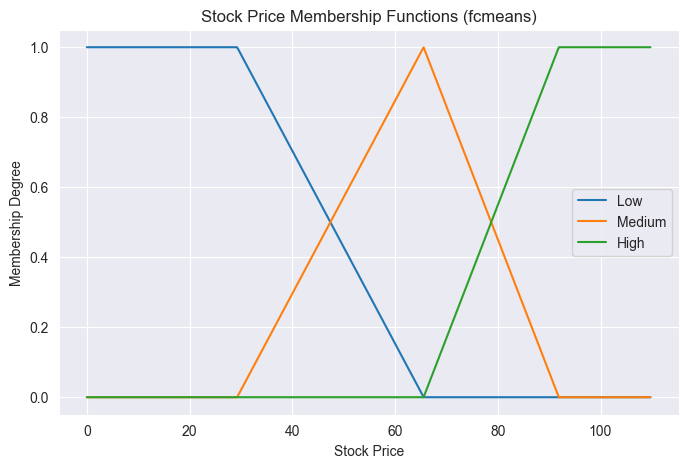

In [73]:
# Instantiate the FCM model with 3 clusters (Low, Medium, High)
fcm = FCM(n_clusters=3, random_state=42)
fcm.fit(selling_price)

# Get the cluster centers and membership matrix
centers = fcm.centers.flatten()
u = fcm.u # Membership degrees (shape: n_samples x n_clusters)

print("Cluster centers:", centers)

# Sort centers and match the memberships accordingly
sorted_idx = np.argsort(centers)
sorted_centers = centers[sorted_idx]
sorted_u = u[:, sorted_idx]

# Plot learned membership functions (fuzzy sets)
x_vals = np.linspace(0, max(selling_price) * 1.1, 1000).flatten()

def create_membership_function(center_idx, centers):
    center = centers[center_idx]
    
    if center_idx == 0:
        # Left shoulder (Slow): extend left
        right = centers[center_idx + 1]
        left = max(0, center - (right - center) * 1.5)
        mf = np.clip((right - x_vals) / (right - center), 0, 1)
        mf[x_vals <= left] = 1.0  # Flat shoulder at 1
    
    elif center_idx == len(centers) - 1:
        # Right shoulder (Fast): extend right
        left = centers[center_idx - 1]
        right = center + (center - left) * 1.5
        mf = np.clip((x_vals - left) / (center - left), 0, 1)
        mf[x_vals >= right] = 1.0  # Flat shoulder at 1
    
    else:
        # Middle triangular (Normal)
        left = centers[center_idx - 1]
        right = centers[center_idx + 1]
        mf = np.clip((x_vals - left) / (center - left), 0, 1) * \
             np.clip((right - x_vals) / (right - center), 0, 1)
        
    return mf

plt.figure(figsize=(8, 5))
labels = ['Low', 'Medium', 'High']
# Flatten arrays to ensure they are 1D
x_vals_flat = x_vals.flatten()
universe_flat = price.universe.flatten()

for i, label in enumerate(labels):
    mf = create_membership_function(i, sorted_centers)
    plt.plot(x_vals, mf, label=label)
    # Interpolation function to project the MF onto the fuzzy universe
    interp_func = interp1d(x_vals_flat, mf, bounds_error=False, fill_value=0)
    # Evaluate it over the universe and assign
    interpolated_mf = interp_func(universe_flat)
    # Assign the membership function (must match universe shape)
    price[label] = interpolated_mf

plt.title("Stock Price Membership Functions (fcmeans)")
plt.xlabel("Stock Price")
plt.ylabel("Membership Degree")
plt.legend()    
plt.grid(True)
plt.show()

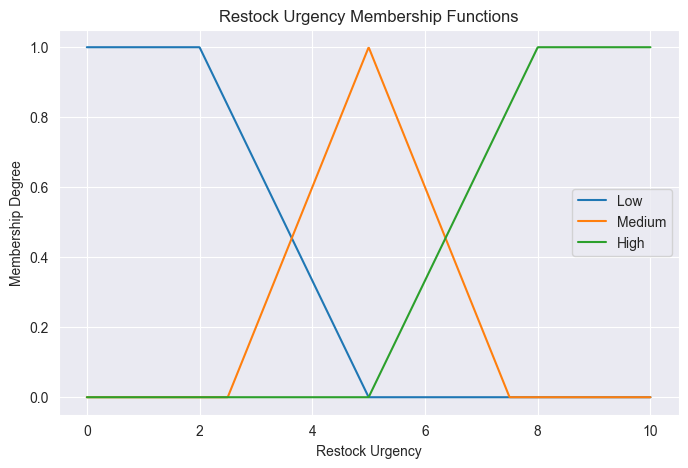

In [74]:
#Since there’s no label or output in the dataset for Restock Urgency, so just define fuzzy sets manually (e.g., Low, Medium, High) over a normalized range (e.g., 0–10).

# Define membership functions
urgency['Low'] = fuzz.trapmf(urgency.universe, [0, 0, 2, 5])
urgency['Medium'] = fuzz.trimf(urgency.universe, [2.5, 5, 7.5])
urgency['High'] = fuzz.trapmf(urgency.universe, [5, 8, 10, 10])

# Plot the membership functions
plt.figure(figsize=(8, 5))
for label in urgency.terms:
    plt.plot(urgency.universe, urgency[label].mf, label=label)

plt.title("Restock Urgency Membership Functions")
plt.xlabel("Restock Urgency")
plt.ylabel("Membership Degree")
plt.legend()
plt.grid(True)
plt.show()

In [75]:
#rules from the expert
rule1 = ctrl.Rule(sales['Fast'] & stock['Low'] & lead['Long'], urgency['High'])
rule2 = ctrl.Rule(sales['Normal'] & stock['Low'] & lead['Normal'], urgency['Medium'])  # fixed
rule3 = ctrl.Rule(sales['Slow'] & stock['Medium'], urgency['Low'])
rule4 = ctrl.Rule(sales['Fast'] & stock['Low'] & lead['Short'], urgency['High'])
rule5 = ctrl.Rule(sales['Fast'] & stock['High'], urgency['Medium'])
rule6 = ctrl.Rule(sales['Fast'] & stock['Low'] & lead['Long'] & price['Low'], urgency['High'])
rule7 = ctrl.Rule(sales['Normal'] & stock['Medium'] & lead['Short'] & price['High'], urgency['Medium'])
rule8 = ctrl.Rule(sales['Slow'] & stock['High'] & lead['Long'] & price['Medium'], urgency['Low'])  # fixed

#top up rules
# Low sales, low stock, long lead — still can be medium urgency
rule9 = ctrl.Rule(sales['Slow'] & stock['Low'] & lead['Long'], urgency['Medium'])
# Normal sales, high stock — likely low urgency
rule10 = ctrl.Rule(sales['Normal'] & stock['High'], urgency['Low'])
# Fast sales, medium stock, long lead — medium urgency
rule11 = ctrl.Rule(sales['Fast'] & stock['Medium'] & lead['Long'], urgency['Medium'])
# Normal sales, medium stock, long lead — low urgency
rule12 = ctrl.Rule(sales['Normal'] & stock['Medium'] & lead['Long'], urgency['Low'])
# Slow sales, low stock, short lead — medium urgency (stock low, but can arrive fast)
rule13 = ctrl.Rule(sales['Slow'] & stock['Low'] & lead['Short'], urgency['Medium'])
# Fast sales, high stock, short lead — low urgency (already well stocked and can get more fast)
rule14 = ctrl.Rule(sales['Fast'] & stock['High'] & lead['Short'], urgency['Low'])
# Normal sales, low stock, long lead — high urgency
rule15 = ctrl.Rule(sales['Normal'] & stock['Low'] & lead['Long'], urgency['High'])
# Slow sales, high stock, short lead — very low urgency
rule16 = ctrl.Rule(sales['Slow'] & stock['High'] & lead['Short'], urgency['Low'])

urgency_ctrl = ctrl.ControlSystem([
    rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8,
    rule9, rule10, rule11, rule12, rule13, rule14, rule15, rule16
])
urgency_sim = ctrl.ControlSystemSimulation(urgency_ctrl)

In [61]:
# --- Sales Speed (Slow, Normal, Fast)
# --- Stock Level (Low, Medium, High)
# --- Lead Time (Short, Normal, Long)
# --- Price (Low, Medium, High)
# --- Restock Urgency (Low, Medium, High)

# --- Rules Based Primarily on Stock Level (Low, Medium, High) ---

# --- Stock is Low ---
# Low stock generally means high urgency, unless sales are very slow AND lead time is very short.
rule_SL_LS_LowUrg = ctrl.Rule(sales['Slow'] & stock['Low'] & lead['Short'], urgency['Medium']) # Slow sales, low stock, short lead -> Medium urgency (can replenish quickly)
rule_SL_LN_MedUrg = ctrl.Rule(sales['Slow'] & stock['Low'] & lead['Normal'], urgency['High']) # Slow sales, low stock, normal lead -> High urgency (stock will deplete before replenishment)
rule_SL_LL_HighUrg = ctrl.Rule(sales['Slow'] & stock['Low'] & lead['Long'], urgency['High'])  # Slow sales, low stock, long lead -> High urgency (need to order immediately)

rule_NL_LS_MedUrg = ctrl.Rule(sales['Normal'] & stock['Low'] & lead['Short'], urgency['Medium']) # Normal sales, low stock, short lead -> Medium urgency (manageable but watch)
rule_NL_LN_HighUrg = ctrl.Rule(sales['Normal'] & stock['Low'] & lead['Normal'], urgency['High']) # Normal sales, low stock, normal lead -> High urgency
rule_NL_LL_HighUrg = ctrl.Rule(sales['Normal'] & stock['Low'] & lead['Long'], urgency['High'])  # Normal sales, low stock, long lead -> High urgency (very risky)

rule_FL_LS_HighUrg = ctrl.Rule(sales['Fast'] & stock['Low'] & lead['Short'], urgency['High']) # Fast sales, low stock, short lead -> High urgency (even with fast replenishment, demand is high)
rule_FL_LN_HighUrg = ctrl.Rule(sales['Fast'] & stock['Low'] & lead['Normal'], urgency['High']) # Fast sales, low stock, normal lead -> High urgency (critical)
rule_FL_LL_HighUrg = ctrl.Rule(sales['Fast'] & stock['Low'] & lead['Long'], urgency['High'])  # Fast sales, low stock, long lead -> High urgency (extreme critical)

# --- Stock is Medium ---
# Medium stock varies in urgency based on sales speed and lead time.
rule_SM_MS_LowUrg = ctrl.Rule(sales['Slow'] & stock['Medium'] & lead['Short'], urgency['Low']) # Slow sales, medium stock, short lead -> Low urgency
rule_SM_MN_LowUrg = ctrl.Rule(sales['Slow'] & stock['Medium'] & lead['Normal'], urgency['Low']) # Slow sales, medium stock, normal lead -> Low urgency
rule_SM_ML_MedUrg = ctrl.Rule(sales['Slow'] & stock['Medium'] & lead['Long'], urgency['Medium']) # Slow sales, medium stock, long lead -> Medium urgency (start planning for long lead)

rule_NM_MS_MedUrg = ctrl.Rule(sales['Normal'] & stock['Medium'] & lead['Short'], urgency['Medium']) # Normal sales, medium stock, short lead -> Medium urgency
rule_NM_MN_MedUrg = ctrl.Rule(sales['Normal'] & stock['Medium'] & lead['Normal'], urgency['Medium']) # Normal sales, medium stock, normal lead -> Medium urgency
rule_NM_ML_HighUrg = ctrl.Rule(sales['Normal'] & stock['Medium'] & lead['Long'], urgency['High']) # Normal sales, medium stock, long lead -> High urgency (risk of depletion)

rule_FM_MS_MedUrg = ctrl.Rule(sales['Fast'] & stock['Medium'] & lead['Short'], urgency['Medium']) # Fast sales, medium stock, short lead -> Medium urgency (can wait slightly)
rule_FM_MN_HighUrg = ctrl.Rule(sales['Fast'] & stock['Medium'] & lead['Normal'], urgency['High']) # Fast sales, medium stock, normal lead -> High urgency
rule_FM_ML_HighUrg = ctrl.Rule(sales['Fast'] & stock['Medium'] & lead['Long'], urgency['High'])  # Fast sales, medium stock, long lead -> High urgency (critical)

# --- Stock is High ---
# High stock generally means low urgency, with few exceptions.
rule_SH_All_LowUrg = ctrl.Rule(stock['High'], urgency['Low']) # General rule for High Stock

# Exceptions for High Stock where urgency might be higher:
# If sales are fast AND lead time is long, even high stock needs reordering soon.
rule_FH_HL_MedUrg = ctrl.Rule(sales['Fast'] & stock['High'] & lead['Long'], urgency['Medium']) # Fast sales, high stock, long lead -> Medium urgency (planning ahead)
# Maybe Fast sales + Normal lead also needs some monitoring
rule_FH_HN_LowUrg = ctrl.Rule(sales['Fast'] & stock['High'] & lead['Normal'], urgency['Low']) # Still Low with normal lead
rule_FH_HS_LowUrg = ctrl.Rule(sales['Fast'] & stock['High'] & lead['Short'], urgency['Low']) # Definitely Low with short lead

# --- Rules with Price Influence (Focusing on high-impact scenarios) ---
# Add price as an intensifier in situations where urgency is already Medium or High.

# Low Stock, High Sales, High Price -> Reinforce High Urgency
rule_FL_Low_HP = ctrl.Rule(sales['Fast'] & stock['Low'] & price['High'], urgency['High']) # Could even add .agg_method(np.max) if you want this rule to potentially override other High rules for max output

# Medium Stock, Normal Sales, Normal Lead, High Price -> Might push towards High
rule_NM_MN_HP = ctrl.Rule(sales['Normal'] & stock['Medium'] & lead['Normal'] & price['High'], urgency['High']) # This could push the Medium to High

# High Stock, Fast Sales, Long Lead, High Price -> Reinforce Medium Urgency
rule_FH_HL_HP = ctrl.Rule(sales['Fast'] & stock['High'] & lead['Long'] & price['High'], urgency['Medium']) # Reinforces Medium urgency in the exception case

# --- Combine all rules into a single ControlSystem ---
urgency_ctrl = ctrl.ControlSystem([
    rule_SL_LS_LowUrg, rule_SL_LN_MedUrg, rule_SL_LL_HighUrg,
    rule_NL_LS_MedUrg, rule_NL_LN_HighUrg, rule_NL_LL_HighUrg,
    rule_FL_LS_HighUrg, rule_FL_LN_HighUrg, rule_FL_LL_HighUrg,
    rule_SM_MS_LowUrg, rule_SM_MN_LowUrg, rule_SM_ML_MedUrg,
    rule_NM_MS_MedUrg, rule_NM_MN_MedUrg, rule_NM_ML_HighUrg,
    rule_FM_MS_MedUrg, rule_FM_MN_HighUrg, rule_FM_ML_HighUrg,
    rule_SH_All_LowUrg,
    rule_FH_HL_MedUrg, rule_FH_HN_LowUrg, rule_FH_HS_LowUrg,
    rule_FL_Low_HP, rule_NM_MN_HP, rule_FH_HL_HP
])

urgency_sim = ctrl.ControlSystemSimulation(urgency_ctrl)


--- Test Case 1: High Demand, Low Stock, Long Lead Time ---
Crisp Restock urgency: 7.939960681749522
Membership of crisp output in each term:
  Low: 0.0000
  Medium: 0.0000
  High: 0.9800


D:\miniconda3\envs\env_python_3_10\lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


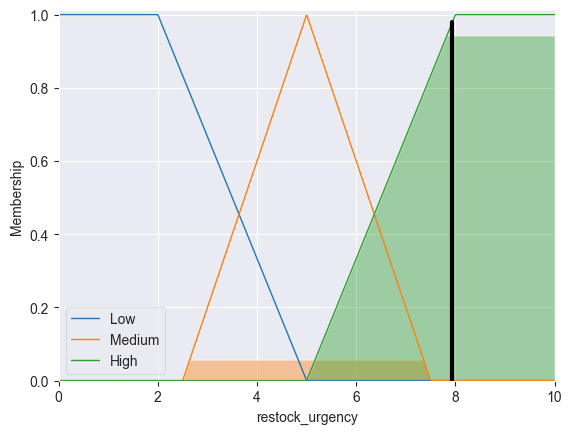

In [80]:
#Scenario: A very popular item that sells quickly is running low on stock, and it takes a long time to get more. This is a critical situation.
print("\n--- Test Case 1: High Demand, Low Stock, Long Lead Time ---")
try:
    urgency_sim.input['sales'] = 380      # High sales (near high cluster center 372.72)
    urgency_sim.input['stock'] = 130      # Low stock (near low cluster center 121.14)
    urgency_sim.input['lead_time'] = 22   # Long lead time (near high cluster center 21.97)
    urgency_sim.input['price'] = 90       # High price (near high cluster center 91.88)

    urgency_sim.compute()
    restock_urgency_output = urgency_sim.output['restock_urgency']
    print("Crisp Restock urgency:", restock_urgency_output)
    print("Membership of crisp output in each term:")
    for label, term in urgency.terms.items():
        membership_degree = fuzz.interp_membership(urgency.universe, term.mf, restock_urgency_output)
        print(f"  {label}: {membership_degree:.4f}")

    urgency.view(sim=urgency_sim) # Uncomment to plot

except KeyError:
    print("Error: 'restock_urgency' not found in output.")
except Exception as e:
    print(f"An error occurred: {e}")

In [82]:
#Scenario: An unpopular item is in high stock, and you can get more quickly if needed. No immediate need to restock.
print("\n--- Test Case 2: Low Demand, High Stock, Short Lead Time ---")
try:
    urgency_sim.input['sales'] = 100      # Low sales (near low cluster center 95.31)
    urgency_sim.input['stock'] = 420      # High stock (near high cluster center 423.03)
    urgency_sim.input['lead_time'] = 10   # Short lead time (near low cluster center 10.18)
    urgency_sim.input['price'] = 30       # Low price (near low cluster center 29.26)
    urgency_sim.compute()
    restock_urgency_output = urgency_sim.output['restock_urgency']
    print("Crisp Restock urgency:", restock_urgency_output)
    print("Membership of crisp output in each term:")
    for label, term in urgency.terms.items():
        membership_degree = fuzz.interp_membership(urgency.universe, term.mf, restock_urgency_output)
        print(f"  {label}: {membership_degree:.4f}")

    # urgency.view(sim=urgency_sim) # Uncomment to plot

except KeyError:
    print("Error: 'restock_urgency' not found in output.")
except Exception as e:
    print(f"An error occurred: {e}")


--- Test Case 2: Low Demand, High Stock, Short Lead Time ---
Crisp Restock urgency: 1.8772263418121584
Membership of crisp output in each term:
  Low: 1.0000
  Medium: 0.0000
  High: 0.0000


In [83]:
#Scenario: Average sales, decent stock levels, and typical replenishment time. A balanced situation requiring standard monitoring.
print("\n--- Test Case 3: Normal Demand, Medium Stock, Normal Lead Time ---")
try:
    urgency_sim.input['sales'] = 210      # Medium sales (near medium cluster center 211.77)
    urgency_sim.input['stock'] = 280      # Medium stock (near medium cluster center 276.52)
    urgency_sim.input['lead_time'] = 17   # Medium lead time (near medium cluster center 16.69)
    urgency_sim.input['price'] = 65       # Medium price (near medium cluster center 65.56)

    urgency_sim.compute()
    restock_urgency_output = urgency_sim.output['restock_urgency']
    print("Crisp Restock urgency:", restock_urgency_output)
    print("Membership of crisp output in each term:")
    for label, term in urgency.terms.items():
        membership_degree = fuzz.interp_membership(urgency.universe, term.mf, restock_urgency_output)
        print(f"  {label}: {membership_degree:.4f}")

    # urgency.view(sim=urgency_sim) # Uncomment to plot

except KeyError:
    print("Error: 'restock_urgency' not found in output.")
except Exception as e:
    print(f"An error occurred: {e}")


--- Test Case 3: Normal Demand, Medium Stock, Normal Lead Time ---
Crisp Restock urgency: 2.455895447083123
Membership of crisp output in each term:
  Low: 0.8480
  Medium: 0.0000
  High: 0.0000


In [85]:
#Scenario: An item is selling quickly, stock is only medium, and it takes a long time to get more. This is a higher urgency situation than case 3.
print("\n--- Test Case 4: Fast Demand, Medium Stock, Long Lead Time ---")
try:
    urgency_sim.input['sales'] = 360      # High sales (approaching high cluster center)
    urgency_sim.input['stock'] = 270      # Medium stock (near medium cluster center 276.52)
    urgency_sim.input['lead_time'] = 21   # Long lead time (near high cluster center 21.97)
    urgency_sim.input['price'] = 70       # Medium-high price (between medium and high clusters)

    urgency_sim.compute()
    restock_urgency_output = urgency_sim.output['restock_urgency']
    print("Crisp Restock urgency:", restock_urgency_output)
    print("Membership of crisp output in each term:")
    for label, term in urgency.terms.items():
        membership_degree = fuzz.interp_membership(urgency.universe, term.mf, restock_urgency_output)
        print(f"  {label}: {membership_degree:.4f}")

    # urgency.view(sim=urgency_sim) # Uncomment to plot

except KeyError:
    print("Error: 'restock_urgency' not found in output.")
except Exception as e:
    print(f"An error occurred: {e}")


--- Test Case 4: Fast Demand, Medium Stock, Long Lead Time ---
Crisp Restock urgency: 4.867513516878811
Membership of crisp output in each term:
  Low: 0.0442
  Medium: 0.9470
  High: 0.0000


In [86]:
#Scenario: A high-value item selling fast, still has high stock, but takes a long time to replenish. Requires proactive planning.
print("\n--- Test Case 5: Fast Demand, High Stock, Long Lead Time, High Price ---")
try:
    urgency_sim.input['sales'] = 350      # High sales (near high cluster center 372.72)
    urgency_sim.input['stock'] = 400      # High stock (near high cluster center 423.03)
    urgency_sim.input['lead_time'] = 22   # Long lead time (near high cluster center 21.97)
    urgency_sim.input['price'] = 92       # High price (near high cluster center 91.88)

    urgency_sim.compute()
    restock_urgency_output = urgency_sim.output['restock_urgency']
    print("Crisp Restock urgency:", restock_urgency_output)
    print("Membership of crisp output in each term:")
    for label, term in urgency.terms.items():
        membership_degree = fuzz.interp_membership(urgency.universe, term.mf, restock_urgency_output)
        print(f"  {label}: {membership_degree:.4f}")

    # urgency.view(sim=urgency_sim) # Uncomment to plot

except KeyError:
    print("Error: 'restock_urgency' not found in output.")
except Exception as e:
    print(f"An error occurred: {e}")



--- Test Case 5: Fast Demand, High Stock, Long Lead Time, High Price ---
Crisp Restock urgency: 4.508981767015801
Membership of crisp output in each term:
  Low: 0.1637
  Medium: 0.8036
  High: 0.0000
